In [1]:
from dmml_project.models.create_model import create_model
from dmml_project.model_selection.load_results import load_results, index_from_model_name
import sklearn.metrics as metrics
from dmml_project.models.model import Model
from dmml_project.models.decision_tree import DecisionTree
from dmml_project.models.random_forest import RandomForest
from dmml_project.models.neural_network import NeuralNetwork
from dmml_project import PROJECT_ROOT, PAPER_IMAGES, PAPER_TABLES
from dmml_project.dataset import Dataset
from dmml_project.utils import dataframe_to_latex
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

try_to_load = True
training_results = load_results()
model_name = "random_forest-G1-0"
generation, model_kind, model_index = index_from_model_name(model_name)
best_params = training_results[generation][model_kind][model_index][0]

match model_kind:
    case "decision_tree":
        model_class = DecisionTree
    case "random_forest":
        model_class = RandomForest
    case "neural_network":
        model_class = NeuralNetwork
    case _:
        raise ValueError(f"Unknown model kind: {model_kind}")

train_dataset: Dataset = Dataset.load(f"{PROJECT_ROOT}/data/train.tsv")
test_dataset: Dataset = Dataset.load(f"{PROJECT_ROOT}/data/test.tsv")
crowdflower_test_dataset: Dataset = Dataset.load(f"{PROJECT_ROOT}/data/crowdflower_test.tsv")
model: Model = create_model(kind=model_kind, **best_params)

Skipping neural_network as no search results were found


In [2]:
history = None
model_path = f"{PROJECT_ROOT}/data/{model_name}.pkl"
can_skip = try_to_load and os.path.exists(model_path)
if can_skip:
    model = model_class.load(model_path)
else:
    history = model.train(train_dataset, valid=test_dataset)
    model.save(f"{PROJECT_ROOT}/data/{model_name}.pkl")


    
def eval_on(model: Model, dataset: Dataset, dataset_name: str):
    accuracy, cm, precision, recall, f1 = model.evaluate(
        dataset, 
        metric=lambda pred, true: 
            (metrics.accuracy_score(pred,true), 
            metrics.confusion_matrix(pred,true, normalize="true"), 
            metrics.precision_score(pred,true, average="macro"), 
            metrics.recall_score(pred,true, average="macro"), 
            metrics.f1_score(pred,true, average="macro"))
        )
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1: {f1*100:.2f}%")
    table = pd.DataFrame(columns=["Metric", "Value"])
    table.loc[len(table)] = ["Accuracy", accuracy]
    table.loc[len(table)] = ["Precision", precision]
    table.loc[len(table)] = ["Recall", recall]
    table.loc[len(table)] = ["F1", f1]

    dataframe_to_latex(
        table, 
        caption=f"Metrics relative to the best model \\texttt{{{model_name.replace("_","\\_")}}} evaluated on the {dataset_name.replace("_"," ")} set.",
        label=f"tab:best_model_metrics_{dataset_name}",
        formatters={
            "Value": lambda x: f"{x*100:.2f}\\%"
        },
        columns_format="|X|r|",
        file=f"{PAPER_TABLES}/best_model_metrics_{dataset_name}.tex"
    )
    fig = plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", annot_kws={"size": 9}, xticklabels=model.classes(), yticklabels=model.classes())
    plt.xlabel("Predicted")
    plt.xticks(rotation=45)
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{PAPER_IMAGES}/best_model_confusion_matrix_{dataset_name}.png")
    plt.show()

In [3]:
if history is not None:
    train_accuracy, valid_accuracy = history
    plt.plot(train_accuracy, label="train")
    plt.plot(valid_accuracy, label="valid")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

Accuracy: 83.98%
Precision: 73.86%
Recall: 83.04%
F1: 76.56%


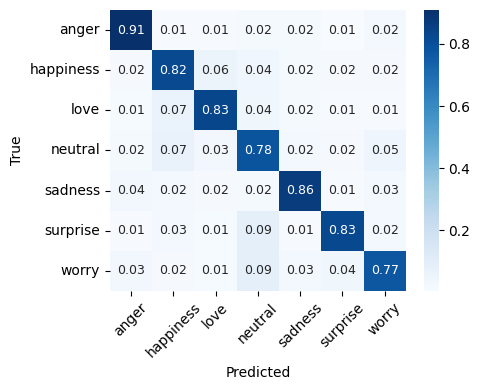

In [4]:
eval_on(model, test_dataset, "test")

Accuracy: 34.50%
Precision: 33.79%
Recall: 29.23%
F1: 28.05%


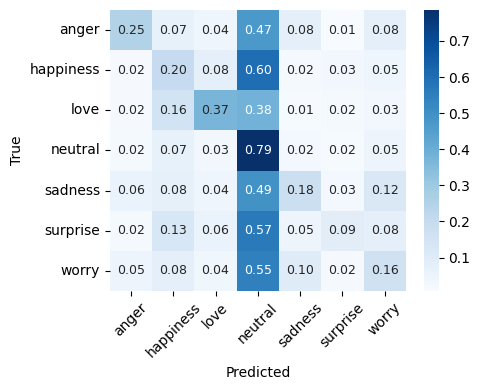

In [5]:
eval_on(model, crowdflower_test_dataset, "crowdflower_test")